**Replication of results**
This notebook is elaborated to replicate the result for project prioritization tool:
1. Data ingestion
2. Exploratory data analysis
3. Data preprocessing (normalization)
4. Indicators building.
5. Coefficients calculation for FEI and SEI indicator.
6. Final FEI and SEI indicators calculation.
7. Prioritization.
8. Visualization (Dashboards)


Libraries installation.

In [1]:
!pip install dash

In [2]:
!python -m pip install pulp

1. Data ingestion

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#Read information of the projects
df = pd.read_excel('/content/proyectos_db.xlsx', 'proyectos_general_v2')

In [5]:
df.head()

,id_proyecto,p_id,nombre_proyecto,tipo,longitud_km,demanda,capex,opex,co2,co2_km,van,pop500m,pop2km,pov_nbi,tec_risk,se_risk,dist,geo_risk
0,1,p1,Extensión Metro Labrador - La Ofelía,Rail,5.40,147617.00,510.000,484.00000,0,0.000000,42.108883,53006.396980,282216.307596,58.678707,0,0,0.811224,0.206590
1,2,p3,Pifo - Baeza,Road,77.33,7412.00,38.665,28.97056,39908,516.073969,40.222281,4157.435309,13989.869220,14.670730,1,0,0.469388,0.203466
2,3,p4,Ámbato - Puyo,Road,129.50,8518.75,134.875,94.08000,57022,440.324324,69.278771,76248.920972,237802.339920,229.214630,0,0,1.000000,0.000000
3,4,p5,Manta - Quevedo,Road,192.00,8588.00,86.400,158.61000,117236,610.604167,53.837539,114030.010233,349904.042448,184.567904,1,0,1.000000,0.801614
4,5,p6,Montecristi - La Cadena,Road,103.85,9125.00,63.910,283.61000,59045,568.560424,1.477875,21942.347719,64526.349191,32.969178,2,1,0.938776,0.762640


In [6]:
def preprocessing_fei(df):
  df['co2_km'] = round(df['co2']/df['longitud_km'],2)
  df['van/capex'] = df['van']/df['capex']
  return df


2. Exploratory data analysis

In [7]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import dash

In [8]:
# Filtrar solo las columnas numéricas
numeric_columns = df.select_dtypes(include='number').columns

# Inicializar la aplicación Dash
app = dash.Dash(__name__)

# Definir el diseño de la aplicación
app.layout = html.Div([
    html.H1(children='EDA Project', style={'textAlign':'center'}),
    dcc.Dropdown(options=[{'label': col, 'value': col} for col in numeric_columns], id='dropdown-selection'),
    dcc.Graph(id='graph-content')
])

# Definir la devolución de llamada para actualizar el gráfico según la selección del menú desplegable
@app.callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)
def update_graph(selected_column):
    if selected_column is None:
        return {}
    else:
        return px.bar(df, x=df.p_id, y=selected_column)

# Ejecutar la aplicación
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

3. Data preprocessing

In [9]:
'''Normalize dataframe columns
Apply MinMax scaler (0,1) from sklearn library'''
from sklearn.preprocessing import MinMaxScaler
def getFEI(df_fei):
  df_norm_fei = pd.DataFrame()
  df_norm_fei['p_id'] = df_fei['p_id']
  df_norm_fei['nombre_proyecto'] = df_fei['nombre_proyecto']
  df_norm_fei['budget'] = df_fei['capex']
  scaler = MinMaxScaler()
  df_norm_fei['van/capex'] = scaler.fit_transform(df_fei[['van/capex']]) #Indicador relacion VAN/CAPEX
  df_norm_fei['tech_risk'] = df_fei['tec_risk'] #Indicador riesgo tecnico
  df_norm_fei['se_risk'] = df_fei['se_risk'] #Indicador riesgo socio ambiental
  df_norm_fei['dist'] = df_fei['dist'] #Indicador distancia a centros productivos
  return df_norm_fei
def getSEI(df_sei):
  df_norm_sei = pd.DataFrame()
  df_norm_sei['p_id'] = df_sei['p_id']
  df_norm_sei['nombre_proyecto'] = df_sei['nombre_proyecto']
  df_norm_sei['budget'] = df_sei['capex']
  df_norm_sei['ben'] = (df['pop2km'] - df['pop2km'].min())/(df['pop2km'].max() - df['pop2km'].min()) #Indicador poblacion beneficiaria en 2 Km
  df_norm_sei['geo_risk'] = df['geo_risk'] #Indicador riesgo geologico concentrado
  df_norm_sei['pov'] = (df['pov_nbi'] - df['pov_nbi'].min())/(df['pov_nbi'].max() - df['pov_nbi'].min()) #Indicador riesgo pobreza a partir de NBI
  df_norm_sei['co2'] = 1- (df['co2_km'] - df['co2_km'].min())/(df['co2_km'].max() - df['co2_km'].min()) #Indicador riesgo de emisiones de CO2
  return df_norm_sei

In [10]:
data_fei = preprocessing_fei(df)
data_norm_fei = getFEI(data_fei)

In [11]:
data_norm_fei.head()

,p_id,nombre_proyecto,budget,van/capex,tech_risk,se_risk,dist
0,p1,Extensión Metro Labrador - La Ofelía,510.000,0.147468,0,0,0.811224
1,p3,Pifo - Baeza,38.665,0.572537,1,0,0.469388
2,p4,Ámbato - Puyo,134.875,0.338800,0,0,1.000000
3,p5,Manta - Quevedo,86.400,0.387386,1,0,1.000000
4,p6,Montecristi - La Cadena,63.910,0.121085,2,1,0.938776


In [12]:
data_norm_sei = getSEI(data_fei)

In [13]:
data_norm_sei[:]

,p_id,nombre_proyecto,budget,ben,geo_risk,pov,co2
0,p1,Extensión Metro Labrador - La Ofelía,510.000,0.286320,0.206590,0.132997,1.000000
1,p3,Pifo - Baeza,38.665,0.000000,0.203466,0.020638,0.739969
2,p4,Ámbato - Puyo,134.875,0.238910,0.000000,0.568401,0.778137
3,p5,Manta - Quevedo,86.400,0.358574,0.801614,0.454411,0.692339
4,p6,Montecristi - La Cadena,63.910,0.053945,0.762640,0.067357,0.713521
5,p7,Loja - Catamayo,86.080,0.045473,0.501727,0.064774,0.730628
6,p8,Buena Fé - Jujan,262.230,0.187434,0.840652,0.184884,0.459618
7,p9,Biblian - Cuenca - Cumbe,242.000,0.318778,0.494383,0.175796,0.000000
8,p10,Daule - El Progreso,92.970,1.000000,0.807674,1.000000,0.518086
9,p11,Tababela - Santa Rosa de Cusubamba,78.610,0.027255,0.470644,0.026601,0.474708


4. Coefficients calculation

In [14]:
# cargar la librería PuLP
from pulp import *
def calcular_coef_sei(escenario):
  """Variables
  p: indice de pobreza de la poblacion relacionada al proyecto
  b: beneficiarios del proyecto
  g: Indice de riesgo de fenomenos naturales
  c: indice de emisiones de CO2"""
  prob = LpProblem("coeficientes", LpMinimize)
  coeficientes = []
  match escenario:
    case 1:
      # Problema de programación lineal
      # 0.3 < p < 1
      p = pulp.LpVariable("p", 3, 100)
      # 0.3 < b < 1
      b = pulp.LpVariable("b", 3, 100)
      # 0.3 < g < 1
      g = pulp.LpVariable('g', 3, 100)
      # 0.3 < c < 1
      c = pulp.LpVariable('c',3, 100)
      #Objetivo
      prob +=  c , "obj"

      # Restricciones
      prob += p + b + g + c == 100, "c1"

      prob += p>= b + 0.03, 'c2'

      prob += b>= g + 0.03, 'c3'

      prob += g >= c + 0.03, 'c4'
      prob += c >= 3 + 0.03, 'c5'

      prob+= p <= 41, 'c6'
      prob.solve()
      coeficientes.append(p.varValue)
      coeficientes.append(b.varValue)
      coeficientes.append(g.varValue)
      coeficientes.append(c.varValue)
    case 2:
      # Problema de programación lineal
      # 0.3 < p < 1
      p = pulp.LpVariable("p", 3, 100)
      # 0.3 < b < 1
      b = pulp.LpVariable("b", 3, 100)
      # 0.3 < g < 1
      g = pulp.LpVariable('g', 3, 100)
      # 0.3 < c < 1
      c = pulp.LpVariable('c',3, 100)
      #Objetivo
      prob +=  c , "obj"

      # Restricciones
      prob += p + b + g + c == 100, "c1"

      prob += b>= p + 0.03, 'c2'

      prob += b>= g + 0.03, 'c3'

      prob += b >= c + 0.03, 'c4'
      prob += c >= 3 + 0.03, 'c5'
      prob+= b <= 41, 'c7'
      prob.solve()
      coeficientes.append(p.varValue)
      coeficientes.append(b.varValue)
      coeficientes.append(g.varValue)
      coeficientes.append(c.varValue)

    case 3:
      # Problema de programación lineal
      # 0.3 < p < 1
      p = pulp.LpVariable("p", 3, 100)
      # 0.3 < b < 1
      b = pulp.LpVariable("b", 3, 100)
      # 0.3 < g < 1
      g = pulp.LpVariable('g', 3, 100)
      # 0.3 < c < 1
      c = pulp.LpVariable('c',3, 100)
      #Objetivo
      prob +=  c , "obj"

      # Restricciones
      prob += p + b + g + c == 100, "c1"

      prob += g>= p + 0.03, 'c2'

      prob += g>= b + 0.03, 'c3'

      prob += g >= c + 0.03, 'c4'
      prob += c >= 3 + 0.03, 'c5'


      prob+= g <= 32.42, 'c7'
      prob.solve()
      coeficientes.append(p.varValue)
      coeficientes.append(b.varValue)
      coeficientes.append(g.varValue)
      coeficientes.append(c.varValue)
    case 4:
      coeficientes = [25 for _ in range(4)]
  return coeficientes

In [15]:
# cargar la librería PuLP
from pulp import *
def calcular_coef_fei(escenario):
  """Coeficientes
  n: coeficiente de indice de capex y VPN
  d: coeficiente de indice de distancia a centros productivos
  t: coeficiente indice de riesgo tecnico de implementación
  s: coeficiente indice de riesgo social de implementación"""
  prob = LpProblem("coeficientes", LpMinimize)
  coeficientes = []
  match escenario:
    case 1:
      # Problema de programación lineal
      # 0.3 < n < 1
      n = pulp.LpVariable("n", 3, 100)
      # 0.3 < d < 1
      d = pulp.LpVariable("d", 3, 100)
      # 0.3 < t < 1
      t = pulp.LpVariable('t', 3, 100)
      # 0.3 < s < 1
      s = pulp.LpVariable('s',3, 100)
      #Objetivo
      prob +=  s , "obj"

      # Restricciones
      prob += n + d + t + s == 100, "c1"

      prob += n>= d + 0.03, 'c2'

      prob += d >= t + 0.03, 'c3'

      prob += t >= s + 0.03, 'c4'
      prob += s >= 3 + 0.03, 'c5'

      prob+= n <= 26, 'c6'
      prob.solve()
      coeficientes.append(n.varValue)
      coeficientes.append(d.varValue)
      coeficientes.append(t.varValue)
      coeficientes.append(s.varValue)
    case 2:
      # Problema de programación lineal
      # 0.3 < n < 1
      n = pulp.LpVariable("n", 3, 100)
      # 0.3 < d < 1
      d = pulp.LpVariable("d", 3, 100)
      # 0.3 < t < 1
      t = pulp.LpVariable('s', 3, 100)
      # 0.3 < s < 1
      s = pulp.LpVariable('c',3, 100)
      #Objetivo
      prob +=  s , "obj"

      # Restricciones
      prob += n + d + t + s == 100, "c1"

      prob += d>= n + 0.03, 'c2'

      prob += d>= t + 0.03, 'c3'

      prob += d >= s + 0.03, 'c4'
      prob += s >= 3 + 0.03, 'c5'
      prob+= d <= 26, 'c7'
      prob.solve()
      coeficientes.append(n.varValue)
      coeficientes.append(d.varValue)
      coeficientes.append(t.varValue)
      coeficientes.append(s.varValue)

    case 3:
      # Problema de programación lineal
      # 0.3 < n < 1
      n = pulp.LpVariable("n", 3, 100)
      # 0.3 < d < 1
      d = pulp.LpVariable("d", 3, 100)
      # 0.3 < t < 1
      t = pulp.LpVariable('t', 3, 100)
      # 0.3 < s < 1
      s = pulp.LpVariable('s',3, 100)
      #Objetivo
      prob +=  s , "obj"

      # Restricciones
      prob += n + d + t + s == 100, "c1"

      prob += t>= n + 0.03, 'c2'

      prob += t>= d + 0.03, 'c3'

      prob += t >= s + 0.03, 'c4'
      prob += s >= 34 + 0.03, 'c5'
      prob += n >= 18.47
      prob+= t >= 35.16, 'c7'
      prob.solve()
      coeficientes.append(n.varValue)
      coeficientes.append(d.varValue)
      coeficientes.append(t.varValue)
      coeficientes.append(s.varValue)
    case 4:
      coeficientes = [25 for _ in range(4)]
  return coeficientes

5. Calculation fo FEI and SEI indicators in four scenarios each one.

In [16]:
def calcularSEIIndex(df_sei_norm,escenario):
  sei_coef = calcular_coef_sei(escenario)
  df_sei_index = pd.DataFrame()
  df_sei_index['p_id'] = df_sei_norm['p_id']
  df_sei_index['nombre_proyecto'] = df_sei_norm['nombre_proyecto']
  df_sei_index['budget'] = df_sei_norm['budget']
  df_sei_index['sei_index'] = sei_coef[0]*df_sei_norm['pov']+sei_coef[1]*df_sei_norm['ben']+sei_coef[2]*df_sei_norm['geo_risk']+sei_coef[3]*df_sei_norm['co2']
  df_sei_index['sei_index'] = (df_sei_index['sei_index']/ df_sei_index['sei_index'].max())*100
  #df_sei_index['sei_norm'] = (df_sei_index['sei_index'] - df_sei_index['sei_index'].min())  / (df_sei_index['sei_index'].max()-df_sei_index['sei_index'].min())*100
  return df_sei_index

In [17]:
def getSEI_Scenarios(df_sei_norm):
  sei_coef = calcular_coef_sei(1)
  df_sei_index = pd.DataFrame()
  df_sei_index['p_id'] = df_sei_norm['p_id']
  df_sei_index['nombre_proyecto'] = df_sei_norm['nombre_proyecto']
  df_sei_index['budget'] = df_sei_norm['budget']
  df_sei_index['sei_index_sc1'] = sei_coef[0]*df_sei_norm['pov']+sei_coef[1]*df_sei_norm['ben']+sei_coef[2]*df_sei_norm['geo_risk']+sei_coef[3]*df_sei_norm['co2']
  df_sei_index['sei_index_sc1'] = (df_sei_index['sei_index_sc1']/ df_sei_index['sei_index_sc1'].max())*100
  sei_coef = calcular_coef_sei(2)
  df_sei_index['sei_index_sc2'] = sei_coef[0]*df_sei_norm['pov']+sei_coef[1]*df_sei_norm['ben']+sei_coef[2]*df_sei_norm['geo_risk']+sei_coef[3]*df_sei_norm['co2']
  df_sei_index['sei_index_sc2'] = (df_sei_index['sei_index_sc2']/ df_sei_index['sei_index_sc2'].max())*100
  sei_coef = calcular_coef_sei(3)
  df_sei_index['sei_index_sc3'] = sei_coef[0]*df_sei_norm['pov']+sei_coef[1]*df_sei_norm['ben']+sei_coef[2]*df_sei_norm['geo_risk']+sei_coef[3]*df_sei_norm['co2']
  df_sei_index['sei_index_sc3'] = (df_sei_index['sei_index_sc3']/ df_sei_index['sei_index_sc3'].max())*100
  sei_coef = calcular_coef_sei(4)
  df_sei_index['sei_index_sc4'] = sei_coef[0]*df_sei_norm['pov']+sei_coef[1]*df_sei_norm['ben']+sei_coef[2]*df_sei_norm['geo_risk']+sei_coef[3]*df_sei_norm['co2']
  df_sei_index['sei_index_sc4'] = (df_sei_index['sei_index_sc4']/ df_sei_index['sei_index_sc4'].max())*100
  return df_sei_index


In [18]:
def calcularFEIIndex(df_fei_norm, escenario):
  fei_coef = calcular_coef_fei(escenario)
  df_fei_index = pd.DataFrame()
  df_fei_index['p_id'] = df_fei_norm['p_id']
  df_fei_index['nombre_proyecto'] = df_fei_norm['nombre_proyecto']
  df_fei_index['budget'] = df_fei_norm['budget']
  df_fei_index['fei_index'] = fei_coef[0]*df_fei_norm['van/capex']+fei_coef[1]*df_fei_norm['dist']+fei_coef[2]*df_fei_norm['tech_risk']+fei_coef[3]*df_fei_norm['se_risk']
  df_fei_index['fei_index'] = (df_fei_index['fei_index']/ df_fei_index['fei_index'].max())*100
  #df_sei_index['sei_norm'] = (df_sei_index['sei_index'] - df_sei_index['sei_index'].min())  / (df_sei_index['sei_index'].max()-df_sei_index['sei_index'].min())*100
  return df_fei_index

In [19]:
def getFEI_Scenarios(df_fei_norm):
  fei_coef = calcular_coef_fei(1)
  df_fei_index = pd.DataFrame()
  df_fei_index['p_id'] = df_fei_norm['p_id']
  df_fei_index['nombre_proyecto'] = df_fei_norm['nombre_proyecto']
  df_fei_index['budget'] = df_fei_norm['budget']
  df_fei_index['fei_index_sc1'] = fei_coef[0]*df_fei_norm['van/capex']+fei_coef[1]*df_fei_norm['dist']+fei_coef[2]*df_fei_norm['tech_risk']+fei_coef[3]*df_fei_norm['se_risk']
  df_fei_index['fei_index_sc1'] = (df_fei_index['fei_index_sc1']/ df_fei_index['fei_index_sc1'].max())*100
  fei_coef = calcular_coef_fei(2)
  df_fei_index['fei_index_sc2'] = fei_coef[0]*df_fei_norm['van/capex']+fei_coef[1]*df_fei_norm['dist']+fei_coef[2]*df_fei_norm['tech_risk']+fei_coef[3]*df_fei_norm['se_risk']
  df_fei_index['fei_index_sc2'] = (df_fei_index['fei_index_sc2']/ df_fei_index['fei_index_sc2'].max())*100
  fei_coef = calcular_coef_fei(3)
  df_fei_index['fei_index_sc3'] = fei_coef[0]*df_fei_norm['van/capex']+fei_coef[1]*df_fei_norm['dist']+fei_coef[2]*df_fei_norm['tech_risk']+fei_coef[3]*df_fei_norm['se_risk']
  df_fei_index['fei_index_sc3'] = (df_fei_index['fei_index_sc3']/ df_fei_index['fei_index_sc3'].max())*100
  sei_coef = calcular_coef_sei(4)
  df_fei_index['fei_index_sc4'] = fei_coef[0]*df_fei_norm['van/capex']+fei_coef[1]*df_fei_norm['dist']+fei_coef[2]*df_fei_norm['tech_risk']+fei_coef[3]*df_fei_norm['se_risk']
  df_fei_index['fei_index_sc4'] = (df_fei_index['fei_index_sc4']/ df_fei_index['fei_index_sc4'].max())*100
  return df_fei_index


In [20]:
table_sei = getSEI_Scenarios(data_norm_sei)

In [21]:
table_sei[:]

,p_id,nombre_proyecto,budget,sei_index_sc1,sei_index_sc2,sei_index_sc3,sei_index_sc4
0,p1,Extensión Metro Labrador - La Ofelía,510.000,24.371208,27.827071,25.219487,48.888288
1,p3,Pifo - Baeza,38.665,6.419164,12.009314,10.294375,28.988046
2,p4,Ámbato - Puyo,134.875,37.060667,22.809438,30.741520,47.671760
3,p5,Manta - Quevedo,86.400,49.598728,62.273846,58.842335,69.365720
4,p6,Montecristi - La Cadena,63.910,19.417014,40.402979,33.368030,48.033012
5,p7,Loja - Catamayo,86.080,14.906171,28.243441,23.872916,40.369768
6,p8,Buena Fé - Jujan,262.230,30.591020,51.061206,44.053516,50.291870
7,p9,Biblian - Cuenca - Cumbe,242.000,28.941223,39.666464,34.675097,29.736260
8,p10,Daule - El Progreso,92.970,100.000000,100.000000,100.000000,100.000000
9,p11,Tababela - Santa Rosa de Cusubamba,78.610,11.191572,24.527976,19.971821,30.044497


In [22]:
table_fei = getFEI_Scenarios(data_norm_fei)

In [23]:
table_fei[:]

,p_id,nombre_proyecto,budget,fei_index_sc1,fei_index_sc2,fei_index_sc3,fei_index_sc4
0,p1,Extensión Metro Labrador - La Ofelía,510.000,18.928098,18.940762,8.076187,8.076187
1,p3,Pifo - Baeza,38.665,40.298141,40.313331,32.678938,32.678938
2,p4,Ámbato - Puyo,134.875,26.435843,26.447469,11.794812,11.794812
3,p5,Manta - Quevedo,86.400,47.113392,47.144013,34.662768,34.662768
4,p6,Montecristi - La Cadena,63.910,77.150171,77.181548,74.945197,74.945197
5,p7,Loja - Catamayo,86.080,37.723015,37.713462,30.391544,30.391544
6,p8,Buena Fé - Jujan,262.230,46.498654,46.530064,34.298402,34.298402
7,p9,Biblian - Cuenca - Cumbe,242.000,47.411472,47.439849,34.997575,34.997575
8,p10,Daule - El Progreso,92.970,40.640512,40.677120,31.023837,31.023837
9,p11,Tababela - Santa Rosa de Cusubamba,78.610,42.601796,42.626817,32.957211,32.957211


5. Project priorization according available budget, FEI and SEI.

In [24]:
#Escenario
def ordenar_sei(df_scenarios_sei, escenario):
  match escenario:
    case 1:
        df_sei_sorted = df_scenarios_sei.sort_values('sei_index_sc1',ascending=True)
    case 2:
        df_sei_sorted = df_scenarios_sei.sort_values('sei_index_sc2',ascending=True)
    case 3:
        df_sei_sorted = df_scenarios_sei.sort_values('sei_index_sc3',ascending=True)
    case 4:
        df_sei_sorted = df_scenarios_sei.sort_values('sei_index_sc4',ascending=True)
  return df_sei_sorted

In [25]:
#Escenario
def ordenar_fei(df_scenarios_fei, escenario):
  match escenario:
    case 1:
        df_fei_sorted = df_scenarios_fei.sort_values('fei_index_sc1',ascending=True)
    case 2:
        df_fei_sorted = df_scenarios_fei.sort_values('fei_index_sc2',ascending=True)
    case 3:
        df_fei_sorted = df_scenarios_fei.sort_values('fei_index_sc3',ascending=True)
    case 4:
        df_fei_sorted = df_scenarios_fei.sort_values('fei_index_sc4',ascending=True)
  return df_fei_sorted

In [26]:
import matplotlib.pyplot as plt
def priorizar(df_scenarios_fei, df_scenarios_sei, escenario_fei = 1, escenario_sei = 1, porcentaje_budget = 40):
  fei_data = ordenar_fei(df_scenarios_fei, escenario_fei)
  sei_data = ordenar_sei(df_scenarios_sei,escenario_sei)
  total_budget = fei_data['budget'].sum()
  limit_budget = (porcentaje_budget/100)*total_budget
  budget_list_fei = fei_data['budget'].tolist()
  acumulado_budget = 0
  n_lim_fei = 0
  for i in range(len(budget_list_fei)):
    if limit_budget > acumulado_budget:
      n_lim_fei += 1
      acumulado_budget += budget_list_fei[i]
    else:
      acumulado_budget +=0
  budget_list_sei = fei_data['budget'].tolist()
  acumulado_budget = 0
  n_lim_sei = 0
  for i in range(len(budget_list_sei)):
    if limit_budget > acumulado_budget:
      n_lim_sei += 1
      acumulado_budget += budget_list_sei[i]
    else:
      acumulado_budget +=0
  return fei_data, sei_data, n_lim_fei, n_lim_sei

6. Visualization (Dashboards)

In [27]:
df_pr_fei, df_pr_sei, lim_fei, lim_sei = priorizar(table_fei, table_sei, 4,4, porcentaje_budget= 40)

limite_sei = len(df_pr_fei)- lim_fei
limite_fei = len(df_pr_sei) - lim_sei

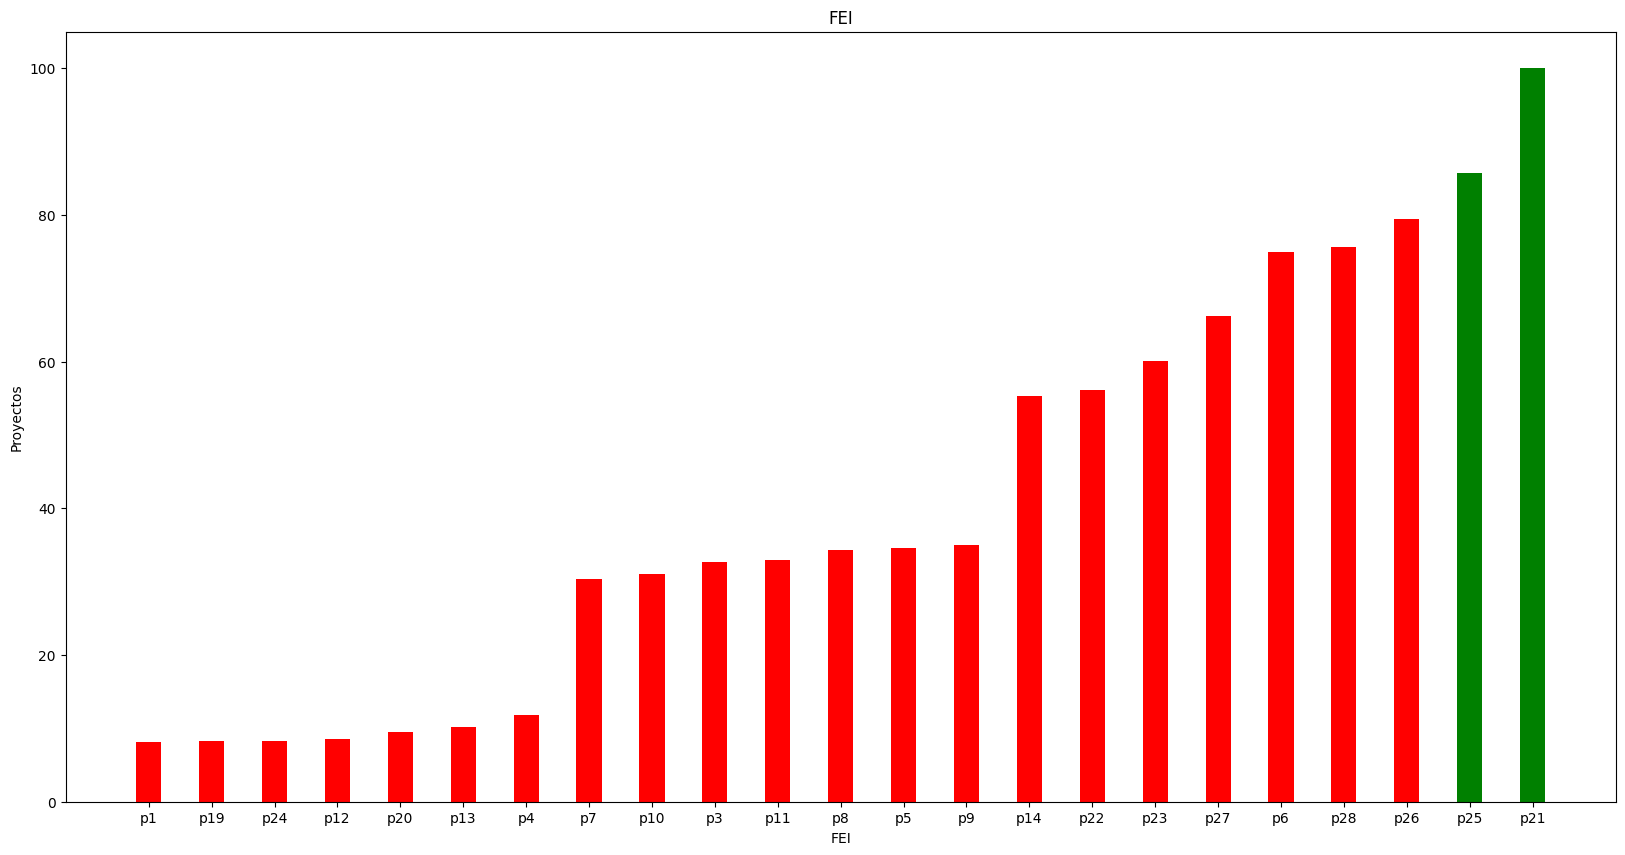

In [28]:
fig = plt.figure(figsize = (20,10))
# creating the bar plot
plt.bar(df_pr_fei['p_id'][:limite_fei], df_pr_fei['fei_index_sc4'][:limite_fei], color='red', width = 0.4)
plt.bar(df_pr_fei['p_id'][limite_fei:], df_pr_fei['fei_index_sc4'][limite_fei:], color='green',width = 0.4)
plt.xlabel("FEI")
plt.ylabel("Proyectos")
plt.title("FEI")
plt.show()

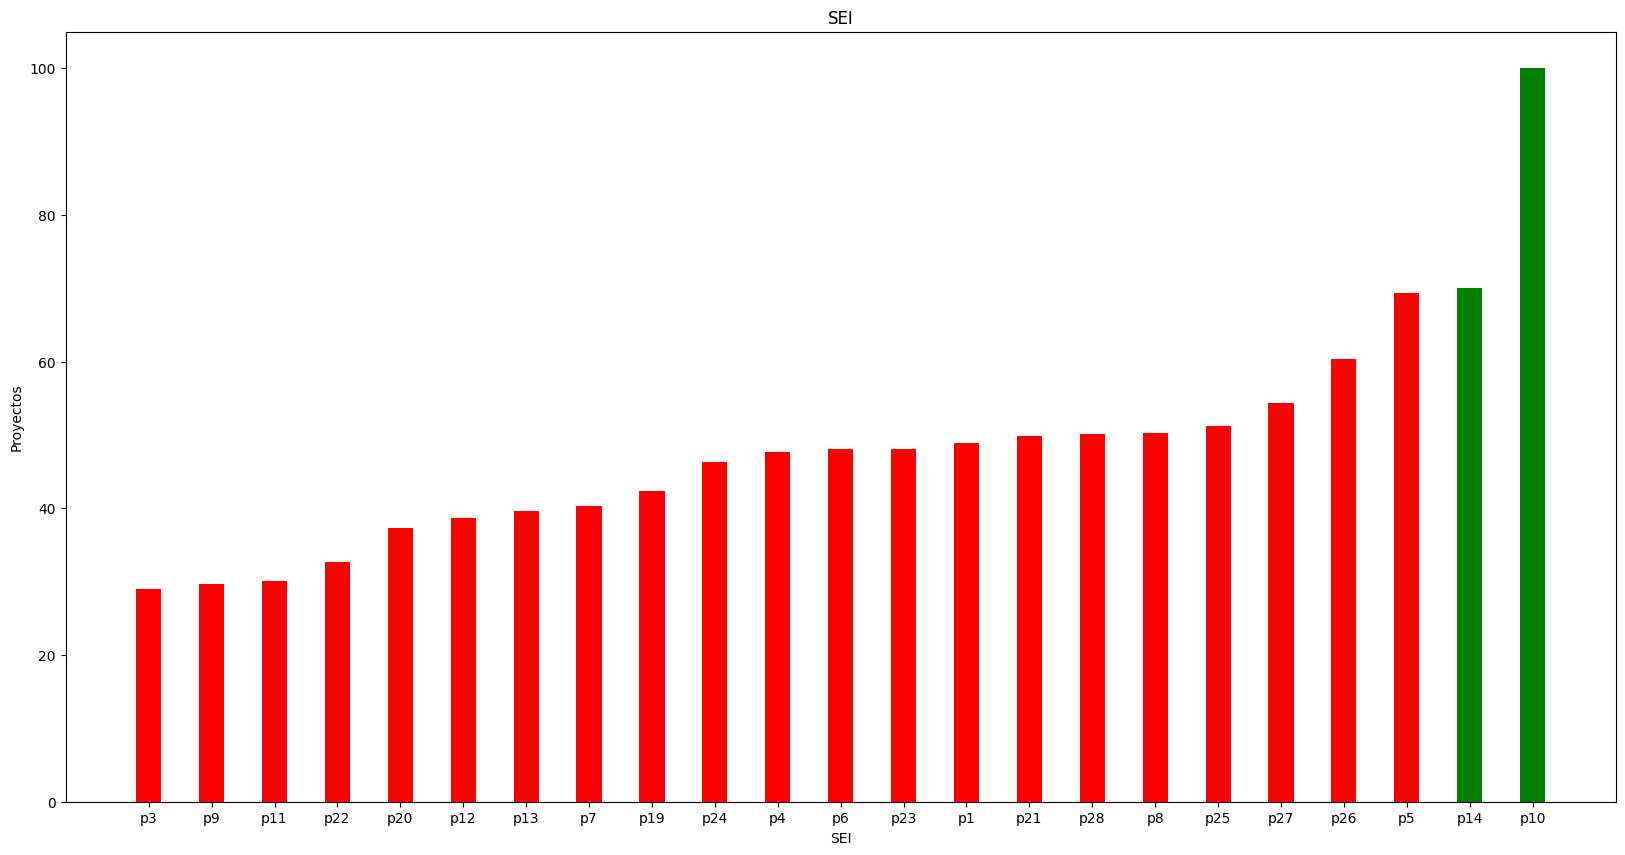

In [29]:
fig = plt.figure(figsize = (20,10))
# creating the bar plot
plt.bar(df_pr_sei['p_id'][:limite_sei], df_pr_sei['sei_index_sc4'][:limite_sei], color='red', width = 0.4)
plt.bar(df_pr_sei['p_id'][limite_sei:], df_pr_sei['sei_index_sc4'][limite_sei:], color='green',width = 0.4)
plt.xlabel("SEI")
plt.ylabel("Proyectos")
plt.title("SEI")
plt.show()

In [30]:
merged_df = pd.merge(df_pr_fei, df_pr_sei)
merged_df[:]

,p_id,nombre_proyecto,budget,fei_index_sc1,fei_index_sc2,fei_index_sc3,fei_index_sc4,sei_index_sc1,sei_index_sc2,sei_index_sc3,sei_index_sc4
0,p1,Extensión Metro Labrador - La Ofelía,510.000,18.928098,18.940762,8.076187,8.076187,24.371208,27.827071,25.219487,48.888288
1,p19,"Viaducto Sur de Guayaquil ""Quinto Puente",666.980,18.183970,18.190614,8.228118,8.228118,21.040592,50.362740,39.720329,42.395381
2,p24,Baeza - Nueva Loja,45.620,17.857099,17.860675,8.330870,8.330870,21.666393,24.853710,26.251498,46.338867
3,p12,Cuenca Girón Pasaje,138.000,19.682866,19.694793,8.503786,8.503786,11.761743,26.185863,21.172158,38.656541
4,p20,Cuenca - Puerto Inca,59.500,19.268829,19.267104,9.464122,9.464122,10.928519,26.118645,20.791257,37.392105
5,p13,Descanso Paute,80.500,23.374647,23.387647,10.197815,10.197815,15.933540,29.116581,23.807076,39.630819
6,p4,Ámbato - Puyo,134.875,26.435843,26.447469,11.794812,11.794812,37.060667,22.809438,30.741520,47.671760
7,p7,Loja - Catamayo,86.080,37.723015,37.713462,30.391544,30.391544,14.906171,28.243441,23.872916,40.369768
8,p10,Daule - El Progreso,92.970,40.640512,40.677120,31.023837,31.023837,100.000000,100.000000,100.000000,100.000000
9,p3,Pifo - Baeza,38.665,40.298141,40.313331,32.678938,32.678938,6.419164,12.009314,10.294375,28.988046


In [31]:
import pandas as pd
import numpy as np
import plotly.express as px
eje_fei = df_pr_fei.loc[limite_fei, 'fei_index_sc4']
print(eje_fei)
eje_sei = df_pr_sei.loc[limite_sei, 'sei_index_sc4']
print(eje_sei)
# Determine the quadrant for each point
merged_df['Quadrant'] = np.select(
    [
        (merged_df['sei_index_sc4'] < eje_sei) & (merged_df['fei_index_sc4'] >= eje_fei),
        (merged_df['sei_index_sc4'] >= eje_sei) & (merged_df['fei_index_sc4'] >= eje_fei),
        (merged_df['sei_index_sc4'] < eje_sei) & (merged_df['fei_index_sc4'] < eje_fei),
        (merged_df['sei_index_sc4'] >= eje_sei) & (merged_df['fei_index_sc4'] < eje_fei),
    ],
    [
        'Top Left', 'Top Right',
        'Bottom Left', 'Bottom Right'
    ],
    default='Not Specified'
)

# Plot with different colors for each quadrant
fig = px.scatter(merged_df, x='fei_index_sc4', y='sei_index_sc4', color='Quadrant', hover_data = 'p_id')

# Add horizontal and vertical lines at the quadrant threshold
fig.add_hline(y=eje_sei, line_dash="dash", annotation_text='<b>40% Budget</b>', annotation_position='top right')
fig.add_vline(x=eje_fei, line_dash="dash", annotation_text='<b>40% Budget</b>', annotation_position='top right')

# Optional: Customize the figure layout to add titles or adjust other aspects
fig.update_layout(
    title="Quadrant Chart",
    xaxis_title="FEI Norm",
    yaxis_title="SEI Norm",
    legend_title="Quadrant"
)

# Show the plot
fig.show()

66.1798192419217
54.318106696172165


In [32]:
!pip install prince

Bonus:
PCA and FAMD analysis of SEI adn FEI

In [33]:
# PCA Analysis for SEI

from sklearn.decomposition import PCA

pca = PCA(n_components=4)
df_pca = pca.fit_transform(data_norm_sei[['ben', 'geo_risk', 'pov', 'co2']])

print(pca.explained_variance_ratio_)


[0.48188238 0.31300226 0.16772109 0.03739427]


In [34]:
import prince

pca = prince.PCA(n_components=4)
pca = pca.fit(data_norm_sei[['ben', 'geo_risk', 'pov', 'co2']])
pca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.955,48.87%,48.87%
1,1.223,30.57%,79.44%
2,0.665,16.63%,96.07%
3,0.157,3.93%,100.00%


In [35]:
famd = prince.FAMD(n_components=4)
famd = famd.fit(data_norm_fei[['van/capex', 'tech_risk','se_risk','dist']])
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.817,30.29%,30.29%
1,1.457,24.29%,54.58%
2,1.060,17.67%,72.25%
3,0.748,12.47%,84.72%


Looking for implementation of Bounded PCA (Constrained)

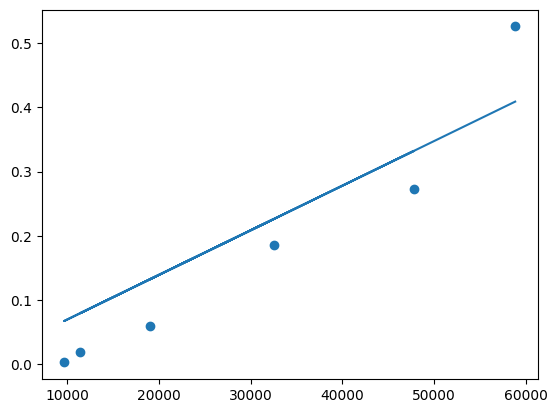

In [36]:
import cvxpy as cp
import numpy as np

A = np.array([[1, 19039],[1, 47792], [1, 9672], [1, 32521], [1, 11409], [1, 58843]])
b = np.array([[0.05938044], [0.27213514], [0.00252875], [0.18535543], [0.01959069], [0.52605937]])
b = np.squeeze(b)
C_min = np.array([[-1, 0]])
C_max = np.array([[1, 65535]])

x = cp.Variable(A.shape[1])

objective = cp.Minimize(0.5 * cp.sum_squares(A@x-b))
constraints = [C_min@x <= 0, C_max@x <= 1]

prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.ECOS)

intercept = x.value[0]
slope = x.value[1]

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.scatter(A[:, 1], b)
plt.plot(A[:, 1], np.multiply(A[:, 1], slope) + intercept)